# LASSO Regression

In this notebook, I take the raw water structure data and perform LASSO regression using hydration free energies, $\mu_{\nu}$, as labels.

## IMPORT MODULES

In [1]:
## MAKE MATPLOTLIB INLINE
%matplotlib inline

## IMPORT OS
import os

## IMPORT RANDOM
import random

## IMPORT NUMPY
import numpy as np  # Used to do math functions

## IMPORT PANDAS
import pandas as pd

## IMPORT REGRESSION FUNCTIONS FROM SKLEARN
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

## IMPORT GLOBAL INPUTS
from sam_analysis.ml_tools.globals import X_DATA_LIST, \
                                          TRAINING_GROUPS, TESTING_GROUPS, \
                                          NH2_GROUPS, CONH2_GROUPS, OH_GROUPS

## IMPORT DATA TOOLS
from sam_analysis.ml_tools.data_tools import rescale_data, \
                                             remove_correlated_features

## FUNCTION TO SAVE AND LOAD PICKLE FILES
from sam_analysis.core.pickles import load_pkl

## IMPORT CHECK SERVER PATH
from sam_analysis.core.check_tools import check_server_path

## IMPORT PLOTTING TOOLS
from sam_analysis.plotting.plots import plot_parity, plot_bar

## SET PATHS AND LOAD DATA
NOTE: "raw_regression_data.pkl" was converted into a pd.dataframe post analysis. Will need to change output of analysis to the data frame to facitate analysis and reproducibility.

In [2]:
## WORKING DIRECTORY
project_dir = r"/home/bdallin/python_projects/sam_analysis/sam_analysis"
data_dir    = "raw_data"

## DATA FILE
data_pkl = r"rescaled_uncorrelated_regression_data.pkl"

## FIGURE PATHS
manuscript_dir = r"/mnt/c/Users/bdallin/Box Sync/univ_of_wisc/manuscripts/chemically_heterogeneous_sams"
fig_dir        = r"figures"
fig_name       = r"minimum_features"

## LOAD DATA
path_data_pkl = os.path.join( project_dir, data_dir, data_pkl )
raw_data      = load_pkl( path_data_pkl )

LOADING PKL FILE...
LOADED PKL FROM /home/bdallin/python_projects/sam_analysis/sam_analysis/raw_data/rescaled_uncorrelated_regression_data.pkl



## PERFORM K-FOLD CV

In [3]:
## FEATURE SET
features  = []
features += [ "theta_48", ]
features += [ "num_hbonds_sam_water", ]
features += [ "hbond_all_0", ]
features += [ "hbond_sam_water_0", ]
features += [ "hbond_water_water_5", ]
    
## CREATE PLACEHOLDERS
y_orig    = []
y_predict = []
weights   = []
rmse      = []
colors    = []

## LOOP THROUGH SAMPLES
for key, data in raw_data.items():
    ## SPLIT TO X AND Y DATA 
    X = data[features]
    y = data["hfe_mu"]

    ## RESCALE DATA
    X = rescale_data( X,
                      columns = X.columns.values,
                      index   = X.index.values ) # outputs np.array
    
    ## GENERATE EMPTY Y PREDICTION ARRAY
    yo = np.empty( shape = ( 0, ) )
    yp = np.empty( shape = ( 0, ) )

    ## GENERATE EMPTY COEFS ARRAY
    rc = np.empty( shape = ( 0, len(features) ) )

    for nn in range( len(TRAINING_GROUPS) ):        
        ## TRAINING DATA
        X_train = X.iloc[ TRAINING_GROUPS[nn], : ]
        y_train = y.iloc[ TRAINING_GROUPS[nn] ]

        ## TEST DATA
        X_test   = X.iloc[ TESTING_GROUPS[nn], : ]
        y_test   = y.iloc[ TESTING_GROUPS[nn] ]

        ## PERFORM RANDOM FOREST REGRESSION
        regressor = RandomForestRegressor( n_estimators = 200,
                                           max_samples  = None,
                                           max_features = 0.5,
                                           max_depth    = None,
                                           random_state = 0,
                                           n_jobs       = 2 )

        ## TRAIN LINEAR REGRESSION MODEL ON TRAINING PCA DATA
        regressor.fit( X_train, y_train )

        ## UPDATE PREDICT Y VALUES
        yp = np.hstack(( yp, regressor.predict( X_test ) ))

        ## UPDATE ORIG ARRAY
        yo = np.hstack(( yo, y_test ))

        ## UPDATE COEFS ARRAY
        rc = np.vstack(( rc, regressor.feature_importances_ ))
        
        ## UPDATE COLOR LIST
        for gg in TESTING_GROUPS[nn]:
            if gg in NH2_GROUPS and gg != 0:
                colors.append( "slateblue" )
            if gg in CONH2_GROUPS and gg != 0:
                colors.append( "darkseagreen" )
            if gg in OH_GROUPS and gg != 0:
                colors.append( "tomato" )
            if gg == 0:
                colors.append( "darkgrey" )
                
    ## COMPUTE MSE & RMSE
    MSE  = metrics.mean_squared_error( yo, yp )
    rmse.append( np.sqrt( MSE ) )

    ## UPDATE LISTS
    y_orig.append( yo )
    y_predict.append( yp )
    weights.append( rc )

## COMPUTE STATISTICS
y_indus     = np.mean( y_orig, axis = 0 )
y_indus_err = np.std( y_orig, axis = 0 )
y_pred      = np.mean( y_predict, axis = 0 )
y_pred_err  = np.std( y_predict, axis = 0 )
RMSE        = np.mean( rmse )
ERR         = np.std( rmse )
coefs       = np.mean( weights, axis = 0 )
coefs_err   = np.std( weights, axis = 0 )

## PLOT PARITY


--- CREATING PARITY PLOT ---
FIGURE SAVED TO: /mnt/c/Users/bdallin/Box Sync/univ_of_wisc/manuscripts/chemically_heterogeneous_sams/figures/k_fold_rf_parity_minimum_features


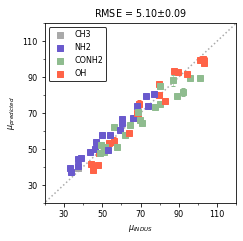

In [4]:
## PLOT PARITY
fig_path = os.path.join( manuscript_dir, fig_dir, "k_fold_rf_parity_{}".format( fig_name ) )
plot_parity( y_indus, y_pred,
             xerr     = y_indus_err,
             yerr     = y_pred_err,
             title    = r"RMSE = {:.2f}$\pm${:.2f}".format( RMSE, ERR ),
             xlabel   = r"$\mu_{INDUS}$",
             ylabel   = r"$\mu_{predicted}$",
             xticks   = [ 30, 110, 20 ],
             yticks   = [ 30, 110, 20 ],
             colors   = colors,
             legend   = [ [ "darkgrey", "slateblue", "darkseagreen", "tomato" ],
                          [ "CH3", "NH2", "CONH2", "OH" ] ],
             fig_path = fig_path, )

## PLOTTING FEATURE WEIGHTS


--- CREATING BAR PLOT ---
FIGURE SAVED TO: /mnt/c/Users/bdallin/Box Sync/univ_of_wisc/manuscripts/chemically_heterogeneous_sams/figures/k_fold_rf_weights_minimum_features


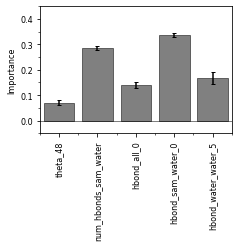

In [5]:
## PLOT SALIENCY
fig_path = os.path.join( manuscript_dir, fig_dir, "k_fold_rf_weights_{}".format( fig_name ) )
plot_bar( [ np.arange( 0, len(features), 1 ) ],
          [ coefs.mean( axis = 0 ) ], 
          yerr     = [ coefs_err.mean( axis = 0 ) ],
          xlabel   = features,
          ylabel   = r"Importance",
          yticks   = [  0,  0.4,  0.1 ],
          colors   = [ "grey" ],
          fig_path = fig_path )

In [6]:
coefs

array([[0.0701532 , 0.28226168, 0.1860775 , 0.30620094, 0.15530667],
       [0.06888023, 0.2921919 , 0.13393995, 0.34425534, 0.16073257],
       [0.08967871, 0.30004085, 0.1121845 , 0.33417783, 0.1639181 ],
       [0.0773063 , 0.28498206, 0.14810605, 0.337067  , 0.15253859],
       [0.04873758, 0.26733643, 0.11929673, 0.36149085, 0.20313841]])